In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import distance_metric, type_metric
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed")
from main import evaluate_clustering

# data imports

In [105]:
energy_complete = pd.read_csv('recs2020.csv')

In [106]:
energy_complete

,DOEID,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,...,EVCHRGHOME,EVCHRGAPT,EVCHRGWKS,EVCHRGBUS,EVCHRGMUNI,EVCHRGDLR,EVCHRGHWY,EVCHRGOTH,EVHOMEAMT,EVCHRGTYPE
0,100001,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3844,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,100002,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,4A,U,3766,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,100003,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3819,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,100004,SOUTH,South Atlantic,45,SC,South Carolina,Mixed-Humid,3A,U,2614,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,100005,NORTHEAST,Middle Atlantic,34,NJ,New Jersey,Mixed-Humid,4A,U,4219,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,118492,SOUTH,South Atlantic,24,MD,Maryland,Mixed-Humid,4A,U,4572,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
18492,118493,NORTHEAST,New England,23,ME,Maine,Very-Cold,7A,R,9861,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
18493,118494,SOUTH,West South Central,48,TX,Texas,Hot-Humid,2A,U,405,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
18494,118495,SOUTH,South Atlantic,45,SC,South Carolina,Hot-Humid,3A,U,1245,...,-2.0,-2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [107]:
energy_complete.columns

Index(['DOEID', 'REGIONC', 'DIVISION', 'STATE_FIPS', 'state_postal',
       'state_name', 'BA_climate', 'IECC_climate_code', 'UATYP10', 'HDD65',
       ...
       'EVCHRGHOME', 'EVCHRGAPT', 'EVCHRGWKS', 'EVCHRGBUS', 'EVCHRGMUNI',
       'EVCHRGDLR', 'EVCHRGHWY', 'EVCHRGOTH', 'EVHOMEAMT', 'EVCHRGTYPE'],
      dtype='object', length=799)

In [108]:
energy_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18496 entries, 0 to 18495
Columns: 799 entries, DOEID to EVCHRGTYPE
dtypes: float64(243), int64(549), object(7)
memory usage: 112.7+ MB


In [109]:
cols_to_keep = [
    "TOTHSQFT", "STORIES", "BEDROOMS", "WALLTYPE", "ROOFTYPE",
    "ADQINSUL", "WINDOWS", "TYPEGLASS",
    "KWH", "DOLLAREL", "CUFEETNG", "DOLLARNG", "USEWOOD", "USESOLAR",
    "KOWNRENT", "NHSLDMEM", "NUMCHILD", "HHAGE", "EDUCATION", "MONEYPY"
]

In [110]:
energy = energy_complete[cols_to_keep].copy()

In [111]:
energy

,TOTHSQFT,STORIES,BEDROOMS,WALLTYPE,ROOFTYPE,ADQINSUL,WINDOWS,TYPEGLASS,KWH,DOLLAREL,CUFEETNG,DOLLARNG,USEWOOD,USESOLAR,KOWNRENT,NHSLDMEM,NUMCHILD,HHAGE,EDUCATION,MONEYPY
0,2100,1,4,1,5,2,4,2,12521.48,1955.06,1217.39,701.83,0,0,1,2,0,65,5,13
1,590,-2,1,1,-2,2,1,2,5243.05,713.27,104.51,261.73,0,0,2,1,0,79,3,6
2,900,-2,1,1,-2,2,1,1,2387.64,334.51,266.93,188.14,0,0,2,1,0,82,4,11
3,2100,2,2,3,5,2,5,2,9275.07,1424.86,552.91,636.91,0,0,1,2,0,70,3,10
4,800,-2,1,7,-2,2,1,2,5869.70,1087.00,376.68,376.04,0,0,2,2,0,30,5,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,1500,2,3,3,5,1,4,2,5638.33,678.15,300.78,420.36,0,0,1,4,2,37,5,2
18492,3070,1,3,3,5,2,4,2,4425.20,649.96,0.00,0.00,0,0,1,1,0,58,2,13
18493,0,-2,3,3,3,2,4,1,15121.25,1428.31,0.00,0.00,0,0,1,4,1,25,3,8
18494,3000,2,3,4,5,2,6,2,18604.35,2222.89,0.00,0.00,0,0,1,1,0,66,4,14


<Axes: >

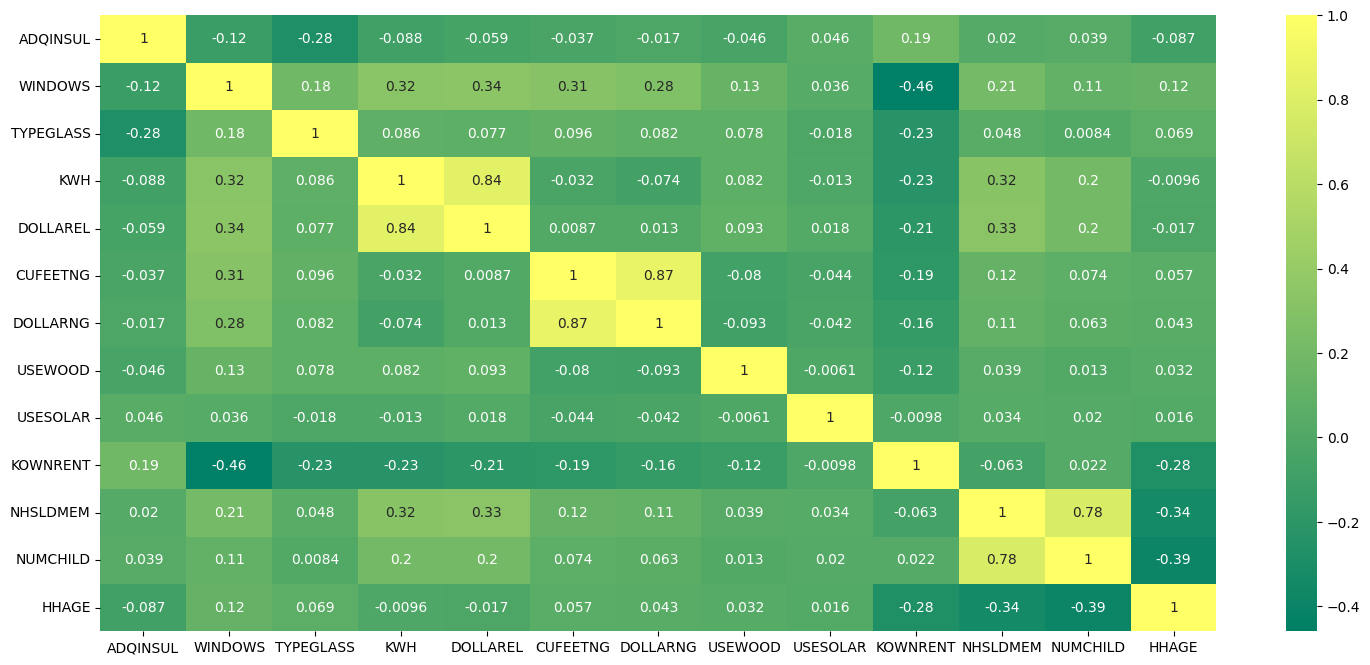

In [112]:
plt.figure(figsize=(18,8))
sns.heatmap(energy.iloc[:,5:-2].corr(),cmap='summer',annot=True)

In [113]:
energy.corr()

,TOTHSQFT,STORIES,BEDROOMS,WALLTYPE,ROOFTYPE,ADQINSUL,WINDOWS,TYPEGLASS,KWH,DOLLAREL,CUFEETNG,DOLLARNG,USEWOOD,USESOLAR,KOWNRENT,NHSLDMEM,NUMCHILD,HHAGE,EDUCATION,MONEYPY
TOTHSQFT,1.000000,0.439822,0.574627,-0.015023,0.060425,-0.251993,0.563149,0.263531,0.385807,0.348779,0.368859,0.288338,0.123113,-0.056804,-0.387101,0.170517,0.092567,0.136055,0.227516,0.376737
STORIES,0.439822,1.000000,0.546011,-0.014500,0.155052,-0.130932,0.531311,0.195927,0.240493,0.246750,0.287256,0.240986,0.119210,0.014562,-0.498351,0.189519,0.110701,0.112531,0.165351,0.353673
BEDROOMS,0.574627,0.546011,1.000000,-0.010480,0.106088,-0.150959,0.601518,0.201103,0.393029,0.373871,0.294991,0.240400,0.099525,0.027508,-0.451212,0.382797,0.242787,0.045969,0.162352,0.348258
WALLTYPE,-0.015023,-0.014500,-0.010480,1.000000,0.025753,0.008746,0.001616,-0.010623,-0.007245,0.002997,-0.016157,-0.022139,0.000357,0.001897,-0.002860,-0.005135,-0.000151,0.000032,-0.004436,-0.002286
ROOFTYPE,0.060425,0.155052,0.106088,0.025753,1.000000,0.014146,0.119596,0.023732,0.040503,0.034049,0.059683,0.045212,0.023242,0.013108,-0.133507,0.015989,0.002269,0.049091,0.020548,0.053422
ADQINSUL,-0.251993,-0.130932,-0.150959,0.008746,0.014146,1.000000,-0.117540,-0.284368,-0.087767,-0.058743,-0.037407,-0.016513,-0.046056,0.046340,0.186754,0.020149,0.039269,-0.086618,-0.099257,-0.182916
WINDOWS,0.563149,0.531311,0.601518,0.001616,0.119596,-0.117540,1.000000,0.179497,0.322728,0.338758,0.314438,0.275980,0.132509,0.035631,-0.459283,0.208391,0.106660,0.118741,0.210621,0.363203
TYPEGLASS,0.263531,0.195927,0.201103,-0.010623,0.023732,-0.284368,0.179497,1.000000,0.085708,0.076870,0.095811,0.081707,0.078193,-0.018137,-0.227485,0.048368,0.008418,0.068687,0.099503,0.220787
KWH,0.385807,0.240493,0.393029,-0.007245,0.040503,-0.087767,0.322728,0.085708,1.000000,0.838835,-0.031975,-0.074409,0.081667,-0.012783,-0.226861,0.316398,0.203775,-0.009582,0.037742,0.191329
DOLLAREL,0.348779,0.246750,0.373871,0.002997,0.034049,-0.058743,0.338758,0.076870,0.838835,1.000000,0.008692,0.013443,0.092557,0.018027,-0.206525,0.331898,0.197118,-0.017048,0.063151,0.222335


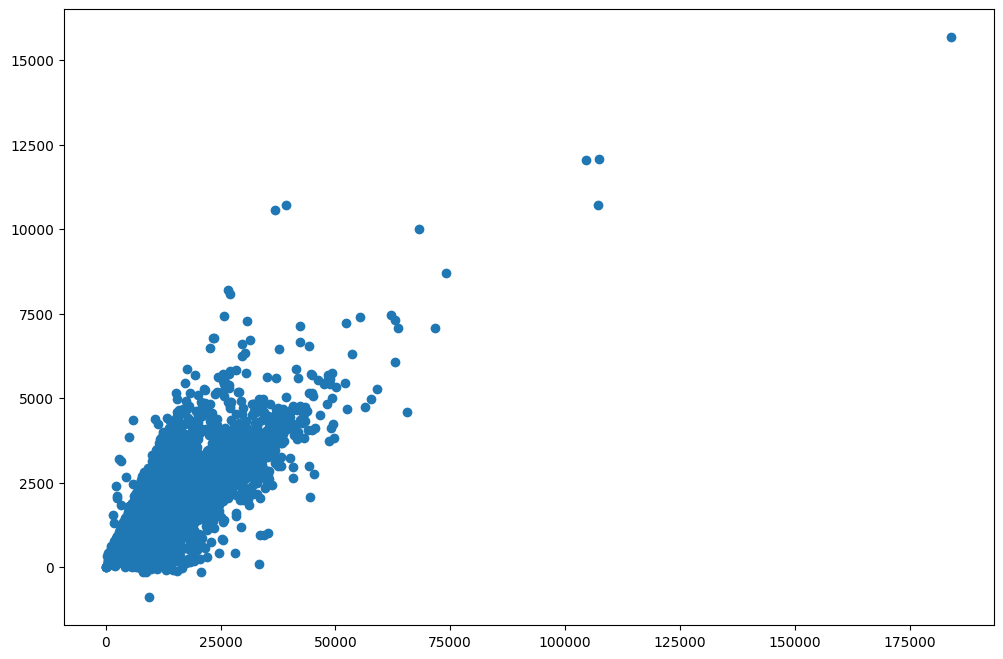

In [114]:
plt.figure(figsize=(12,8))
plt.scatter(energy.iloc[:,8], energy.iloc[:,9])

# data standardization

In [115]:
energy

,TOTHSQFT,STORIES,BEDROOMS,WALLTYPE,ROOFTYPE,ADQINSUL,WINDOWS,TYPEGLASS,KWH,DOLLAREL,CUFEETNG,DOLLARNG,USEWOOD,USESOLAR,KOWNRENT,NHSLDMEM,NUMCHILD,HHAGE,EDUCATION,MONEYPY
0,2100,1,4,1,5,2,4,2,12521.48,1955.06,1217.39,701.83,0,0,1,2,0,65,5,13
1,590,-2,1,1,-2,2,1,2,5243.05,713.27,104.51,261.73,0,0,2,1,0,79,3,6
2,900,-2,1,1,-2,2,1,1,2387.64,334.51,266.93,188.14,0,0,2,1,0,82,4,11
3,2100,2,2,3,5,2,5,2,9275.07,1424.86,552.91,636.91,0,0,1,2,0,70,3,10
4,800,-2,1,7,-2,2,1,2,5869.70,1087.00,376.68,376.04,0,0,2,2,0,30,5,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,1500,2,3,3,5,1,4,2,5638.33,678.15,300.78,420.36,0,0,1,4,2,37,5,2
18492,3070,1,3,3,5,2,4,2,4425.20,649.96,0.00,0.00,0,0,1,1,0,58,2,13
18493,0,-2,3,3,3,2,4,1,15121.25,1428.31,0.00,0.00,0,0,1,4,1,25,3,8
18494,3000,2,3,4,5,2,6,2,18604.35,2222.89,0.00,0.00,0,0,1,1,0,66,4,14


In [116]:
scaler = StandardScaler()

In [117]:
energy_scaled = scaler.fit_transform(energy.iloc[:,1:])

In [118]:
np.mean(energy_scaled),np.std(energy_scaled)

(2.038071041380728e-17, 1.0)

In [119]:
energy_scaled = pd.DataFrame(energy_scaled)

In [120]:
energy_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033


# dimensionality reduction algorithms

## pca 

In [121]:
pca_general = PCA()

In [122]:
pca_general.fit(energy_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [123]:
explained_variance = pca_general.explained_variance_ratio_

In [124]:
explained_variance

array([0.2146546 , 0.11663566, 0.0971468 , 0.06998024, 0.05859661,
       0.05802086, 0.05291929, 0.05108074, 0.04922519, 0.04322962,
       0.03709562, 0.0312223 , 0.02781238, 0.0242949 , 0.02354329,
       0.01968774, 0.01034948, 0.00848455, 0.00602012])

In [125]:
eigenvalues = pca_general.explained_variance_

In [126]:
eigenvalues

array([4.07865784, 2.21619736, 1.84588901, 1.32969637, 1.11339577,
       1.10245603, 1.00552094, 0.97058657, 0.93532912, 0.82140719,
       0.70485492, 0.59325576, 0.52846376, 0.46162811, 0.4473467 ,
       0.37408738, 0.19665084, 0.16121518, 0.11438847])

In [127]:
selected_components = []

for i in eigenvalues:
    if i > 1:
        selected_components.append(i)
    
print(selected_components)

[4.078657841498473, 2.216197360877422, 1.8458890118985283, 1.3296963713635903, 1.1133957662015803, 1.1024560258406808, 1.0055209351187568]


In [128]:
N_COMPONENTS = len(selected_components)

In [129]:
eigenvectors = pca_general.components_

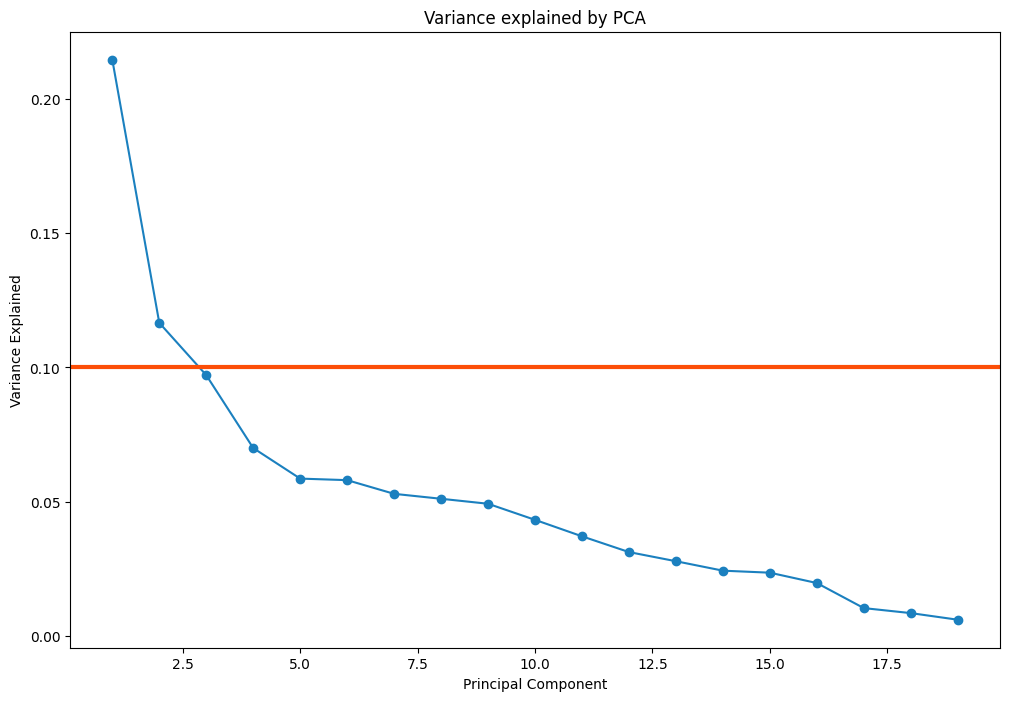

In [130]:
plt.figure(figsize=(12,8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='#1B80BF')
plt.axhline(y=0.1, color='#FC4E07', linewidth=3)
plt.title('Variance explained by PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [131]:
pca = PCA(n_components=N_COMPONENTS)

In [132]:
X_pca = pca.fit_transform(energy_scaled)

In [133]:
pd.DataFrame(X_pca).head(8)

,0,1,2,3,4,5,6
0,1.673395,-1.447126,0.508230,0.023148,-0.122786,-1.154415,-0.182414
1,-3.864217,-0.675604,-0.202430,-0.044917,-1.145874,-0.237309,-0.333576
2,-3.877527,-0.966617,0.358127,0.408006,0.110647,-1.063763,-0.343136
3,0.269127,-1.366473,-0.168381,-0.733616,-0.253017,0.129371,-0.033986
4,-2.413210,0.283355,1.160558,2.592703,-0.076027,-1.479571,0.795753
5,1.518728,1.747558,0.081802,0.566414,0.113387,0.908183,-0.388648
6,1.229702,3.344807,3.022299,-0.937066,-0.492172,1.345803,-0.338726
7,-2.677784,0.844500,-0.441846,0.364921,-0.933692,-0.552196,0.037084


In [134]:
pca_columns = [f'dim_{i+1}' for i in range(N_COMPONENTS)]

In [135]:
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

In [136]:
pca_data

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7
0,1.673395,-1.447126,0.508230,0.023148,-0.122786,-1.154415,-0.182414
1,-3.864217,-0.675604,-0.202430,-0.044917,-1.145874,-0.237309,-0.333576
2,-3.877527,-0.966617,0.358127,0.408006,0.110647,-1.063763,-0.343136
3,0.269127,-1.366473,-0.168381,-0.733616,-0.253017,0.129371,-0.033986
4,-2.413210,0.283355,1.160558,2.592703,-0.076027,-1.479571,0.795753
...,...,...,...,...,...,...,...
18491,0.314236,0.737734,1.177602,1.004240,-0.478281,1.612559,0.009503
18492,-0.927692,-0.993445,-0.927848,0.176300,0.100839,0.946557,-0.090252
18493,-0.767013,2.387045,0.174900,-0.227717,0.214564,-0.149843,0.079138
18494,1.220669,-0.478075,-2.129081,0.104131,0.408176,-0.989836,0.192235


## t-SNE

In [137]:
tsne = TSNE(n_components=3,random_state=42)

In [138]:
X_tsne = tsne.fit_transform(energy_scaled)

In [139]:
tsne_columns = [f'dim_{i+1}' for i in range(3)]

In [140]:
tsne_data = pd.DataFrame(X_tsne, columns=tsne_columns)

In [141]:
tsne_data

,dim_1,dim_2,dim_3
0,16.268520,-3.735864,7.659963
1,-29.575392,-11.788442,1.968086
2,-29.156906,13.369072,6.001029
3,9.330500,-10.219470,17.929407
4,-22.185717,-10.707845,-9.793302
...,...,...,...
18491,-2.790529,1.475080,5.960821
18492,-0.983179,-16.624762,9.325651
18493,-10.824694,5.492676,12.171021
18494,5.137509,-14.941869,1.343274


## umap

In [142]:
umap = umap.UMAP(n_components=3,random_state=42)

In [143]:
X_umap = umap.fit_transform(energy_scaled)

In [144]:
umap_columns = [f'dim_{i+1}' for i in range(3)]

In [145]:
umap_data = pd.DataFrame(X_umap, columns=umap_columns)

# clustering algorithms

## k-means 

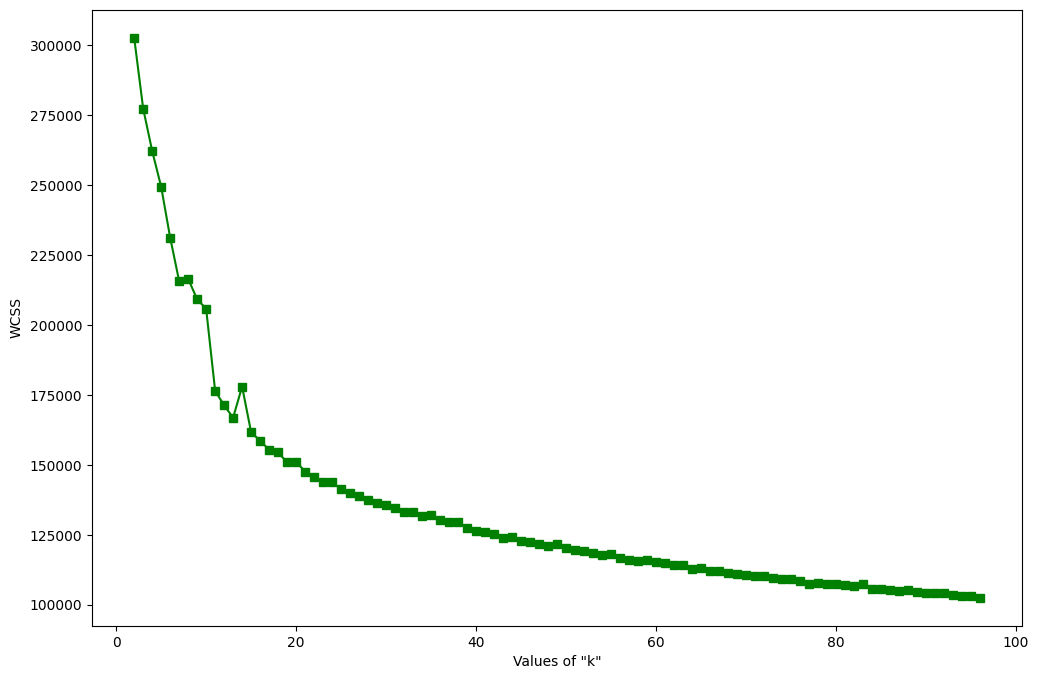

In [146]:
limit = int((energy_scaled.shape[0]//2)**0.5)
wcss = {}

for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(energy_scaled)
    wcss[k] = model.inertia_
    
plt.figure(figsize=(12,8))
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.15265785592294448
For n_clusters = 3 The average silhouette_score is : 0.14321298199523294
For n_clusters = 4 The average silhouette_score is : 0.12095254262028737
For n_clusters = 5 The average silhouette_score is : 0.11462770372733809
For n_clusters = 6 The average silhouette_score is : 0.11934084729580463


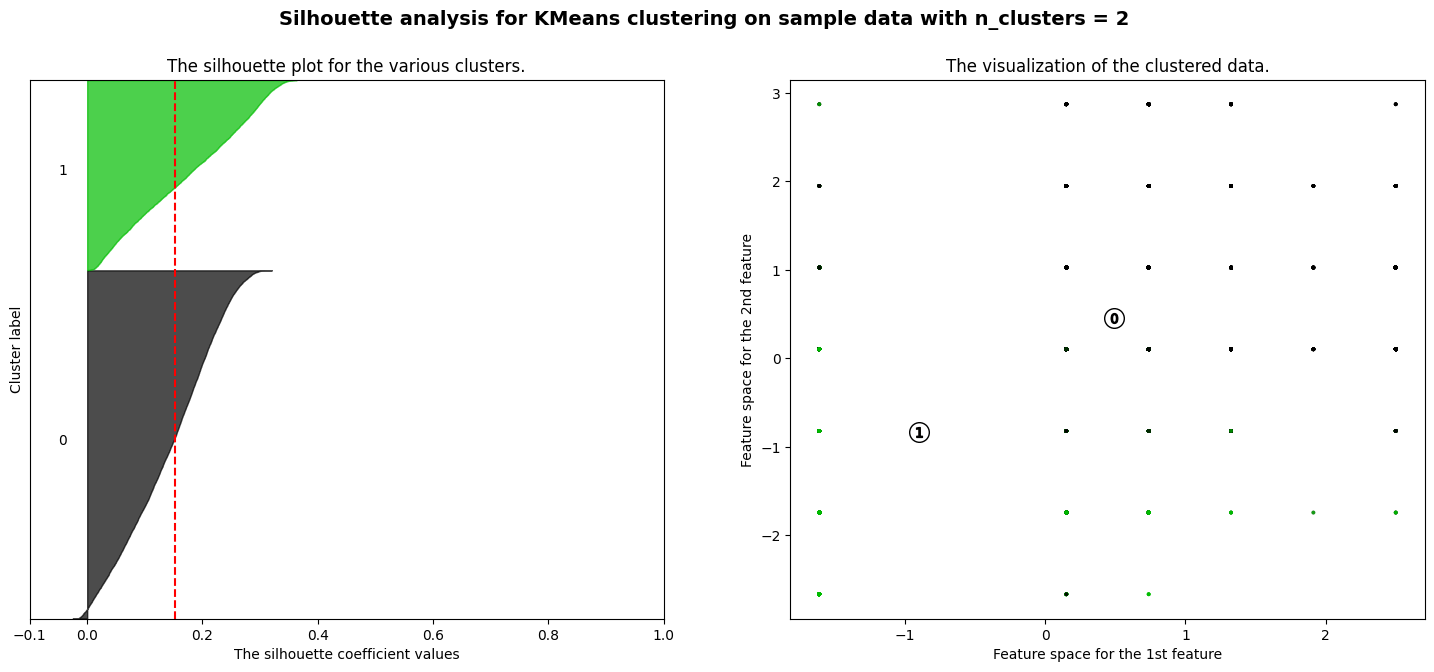

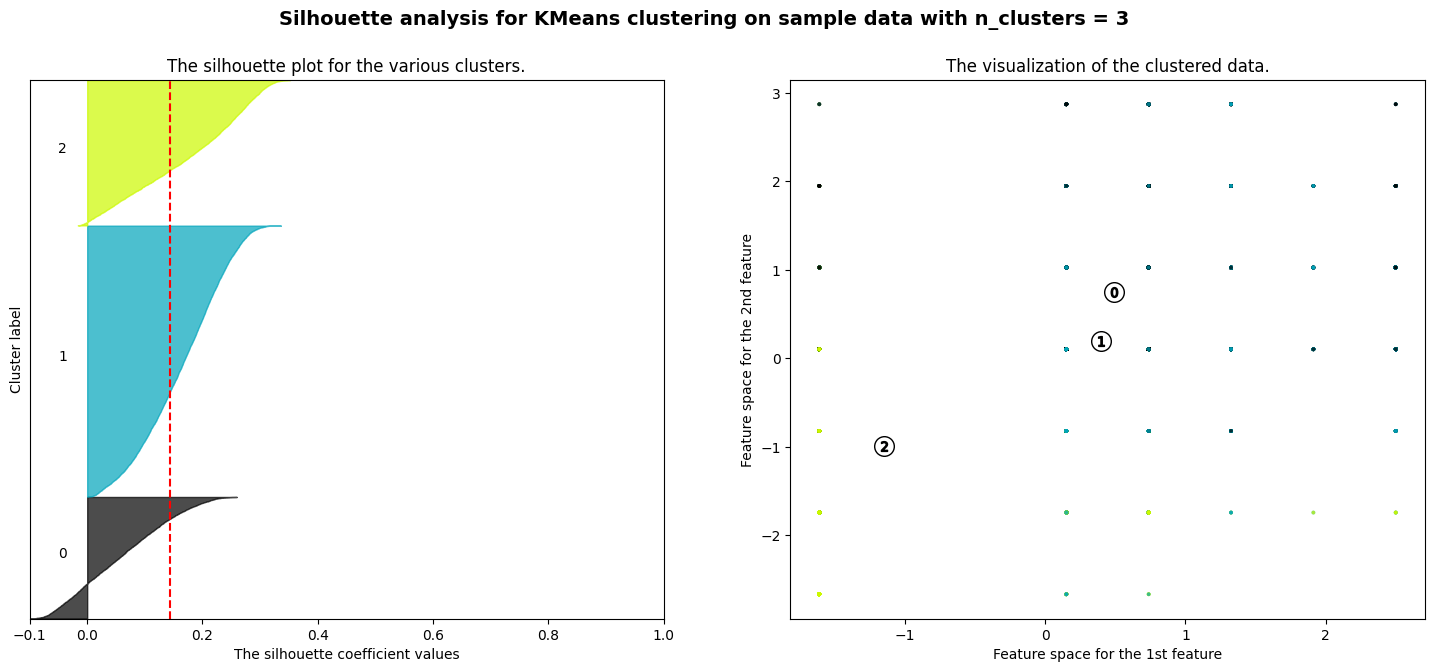

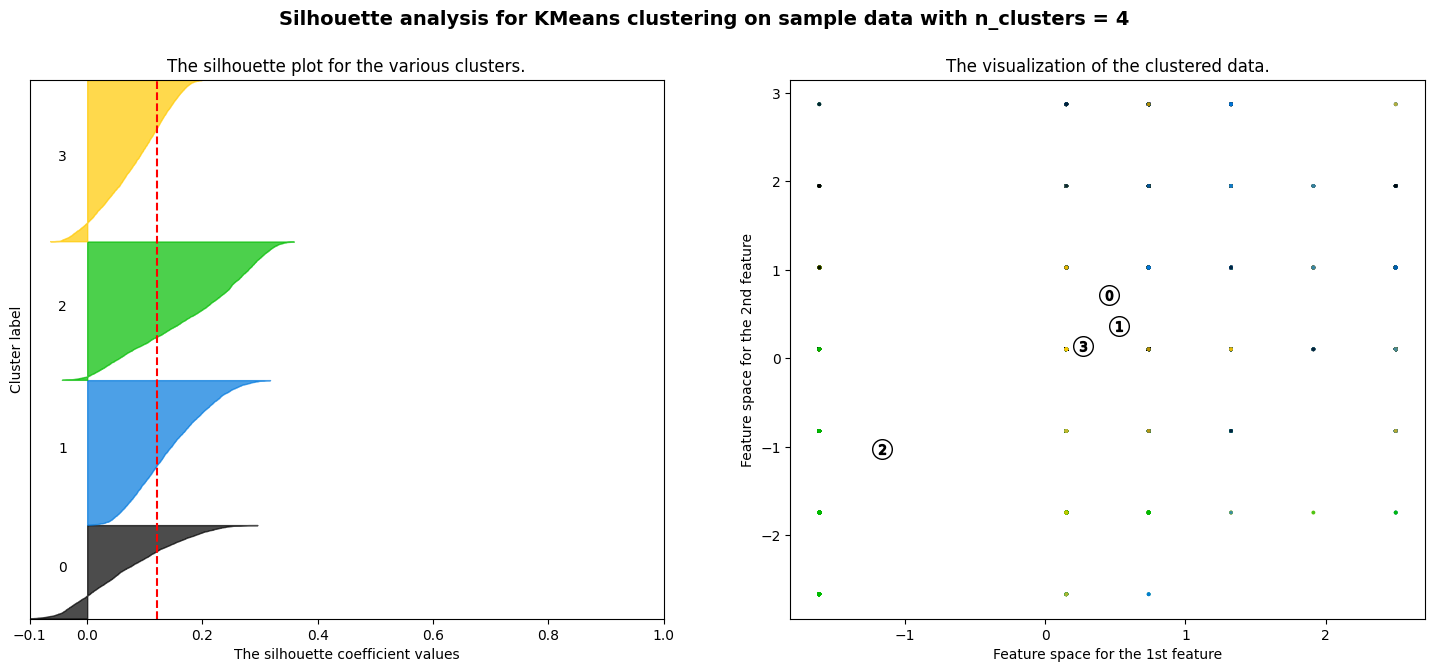

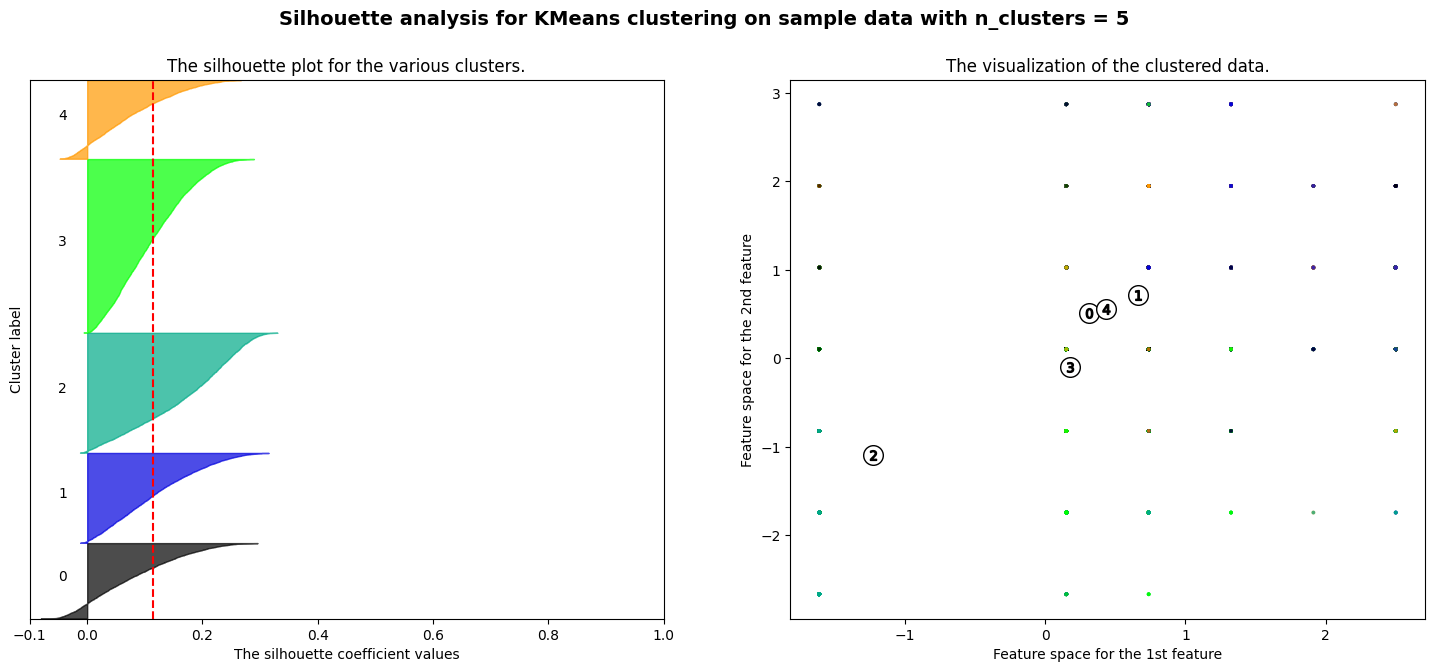

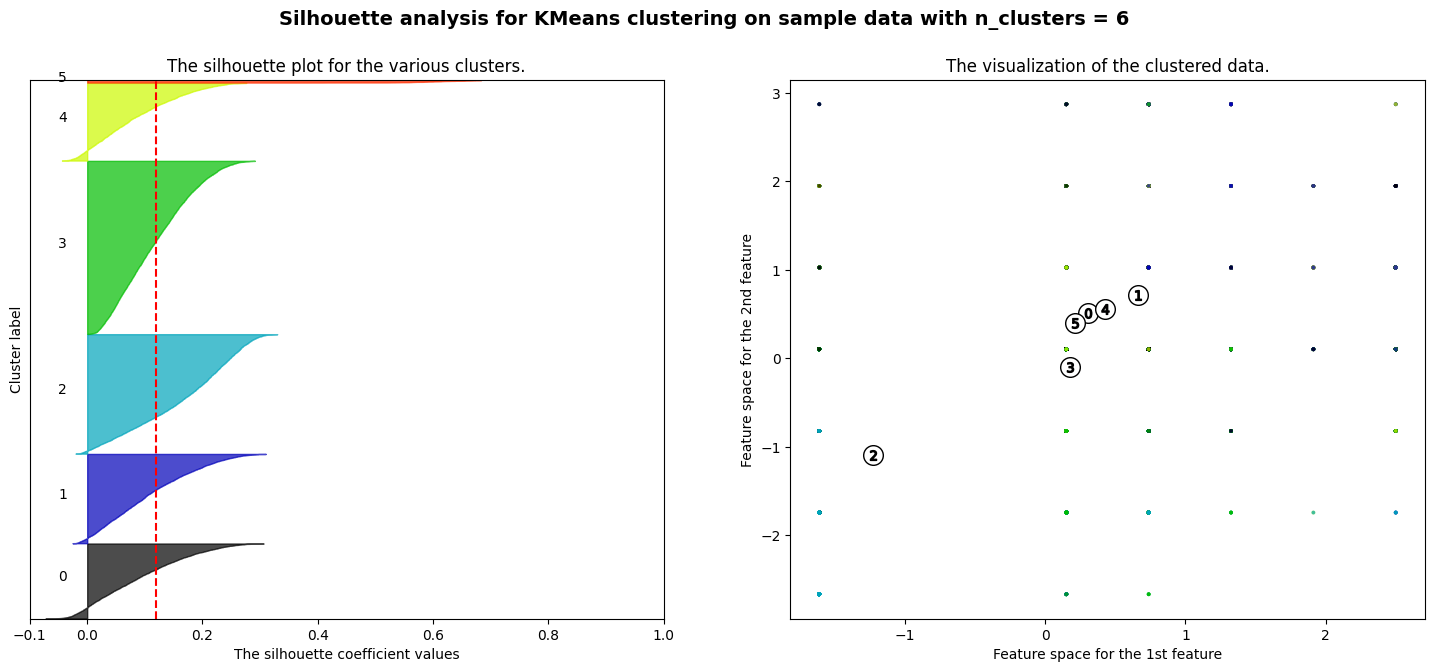

In [147]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(energy_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(energy_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(energy_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(energy_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        energy_scaled.values[:, 0], energy_scaled.values[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [148]:
kmeans = KMeans(n_clusters=5,init='k-means++',random_state=42)

In [149]:
kmeans.fit(energy_scaled)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [150]:
df_kmeans = energy_scaled.copy()

In [151]:
df_kmeans['k_means'] = kmeans.labels_

In [152]:
df_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,k_means
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,4
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,1
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,1
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,3
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,3
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,2


In [153]:
df_kmeans['k_means'].unique()

array([4, 1, 3, 0, 2])

In [154]:
df_kmeans.groupby(df_kmeans['k_means']).mean() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
k_means,,,,,,,,,,,,,,,,,,,
0,0.309360,0.517778,0.016197,0.029174,0.122699,0.170969,-0.014695,0.321958,0.287511,0.038238,0.018806,-0.058379,0.059760,-0.006481,1.655660,1.918638,-0.814467,-0.045015,0.146360
1,-1.229979,-1.093645,0.003260,-0.348832,0.354778,-1.036221,-0.482949,-0.585733,-0.560754,-0.446975,-0.385991,-0.258525,-0.026876,1.423330,-0.454557,-0.279546,-0.434815,-0.207159,-0.650846
2,0.431055,0.554054,-0.033721,0.022056,-0.247785,0.610567,0.248234,1.336938,1.303447,-0.587787,-0.577957,0.572341,0.043637,-0.460620,0.128594,-0.180611,0.125749,0.206111,0.485826
3,0.175107,-0.092047,0.034709,0.155776,-0.080194,-0.069964,0.068167,-0.327583,-0.364013,-0.187376,-0.184189,0.004081,0.003848,-0.517663,-0.509712,-0.483976,0.519290,-0.211455,-0.160183
4,0.665066,0.716691,-0.055364,0.120561,-0.204154,0.838550,0.307253,-0.025567,0.069490,1.437966,1.358279,-0.114616,-0.059760,-0.489804,0.090030,-0.142705,0.149764,0.541236,0.628795


### k-means with pca

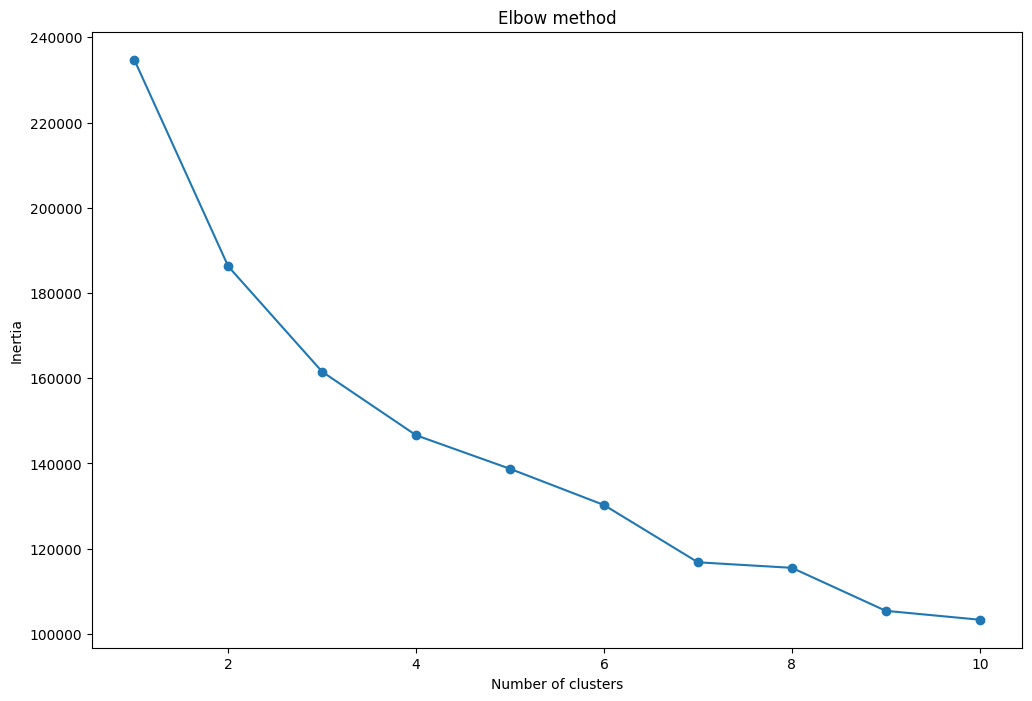

In [155]:
data = X_pca
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [156]:
kmeans_pca = KMeans(n_clusters=5,init='k-means++',random_state=42)

In [157]:
kmeans_pca.fit(X_pca)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [158]:
df_pca_kmeans = energy_scaled.copy()

In [159]:
df_pca_kmeans["kmeans_pca"] = kmeans_pca.labels_

In [160]:
df_pca_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,kmeans_pca
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,2
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,4
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,2
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,4


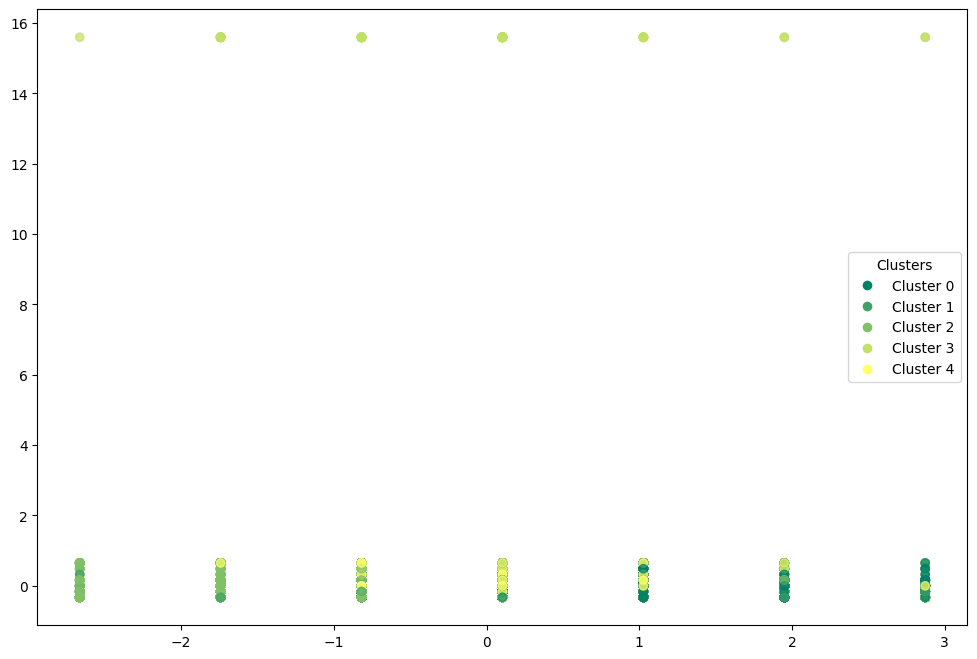

In [161]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pca_kmeans.iloc[:, 1], df_pca_kmeans.iloc[:, 2], 
                      c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [162]:
df_pca_kmeans.groupby(df_pca_kmeans['kmeans_pca']).mean() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
kmeans_pca,,,,,,,,,,,,,,,,,,,
0,0.458214,0.726431,-0.048689,0.024483,0.008609,0.448733,0.103352,0.730209,0.725577,0.131871,0.105363,0.075427,0.027302,-0.181009,1.516758,1.614664,-0.727883,0.135698,0.366205
1,0.521210,0.357430,-0.069408,0.126499,-0.127720,0.449985,0.210768,-0.274199,-0.233658,1.019116,0.970892,-0.190301,-0.066188,-0.491570,-0.241936,-0.366755,0.338916,0.277834,0.353907
2,-1.142167,-1.024151,-0.072944,-0.305938,0.376787,-0.975069,-0.499819,-0.592503,-0.575634,-0.428590,-0.373129,-0.272692,-0.029734,1.180856,-0.414634,-0.231089,-0.351601,-0.247980,-0.676079
3,-0.306486,-0.267545,15.593509,0.314765,0.112769,0.020279,-0.170605,-0.098292,-0.022132,-0.146978,-0.219981,0.104167,-0.069141,0.107451,-0.204515,-0.056009,-0.027379,-0.082248,-0.128532
4,0.262147,0.141311,-0.050073,0.137251,-0.225133,0.180083,0.190700,0.329184,0.279053,-0.627611,-0.615653,0.368124,0.070929,-0.491231,-0.340175,-0.451586,0.450975,-0.115300,0.054715


### k-means with t-SNE

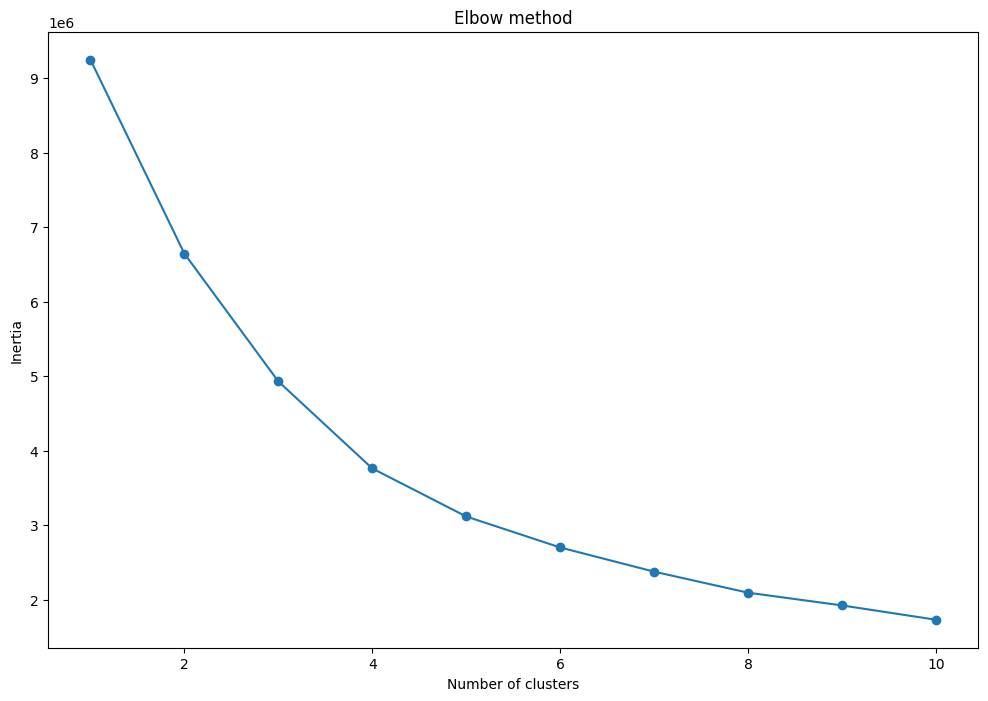

In [163]:
data = X_tsne
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [164]:
kmeans_tsne = KMeans(n_clusters=5,init='k-means++',random_state=42)

In [165]:
kmeans_tsne.fit(X_tsne)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [166]:
df_tsne_kmeans = energy_scaled.copy()

In [167]:
df_tsne_kmeans['kmeans_tsne'] = kmeans_tsne.labels_

In [168]:
df_tsne_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,kmeans_tsne
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,3
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,2
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,1
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


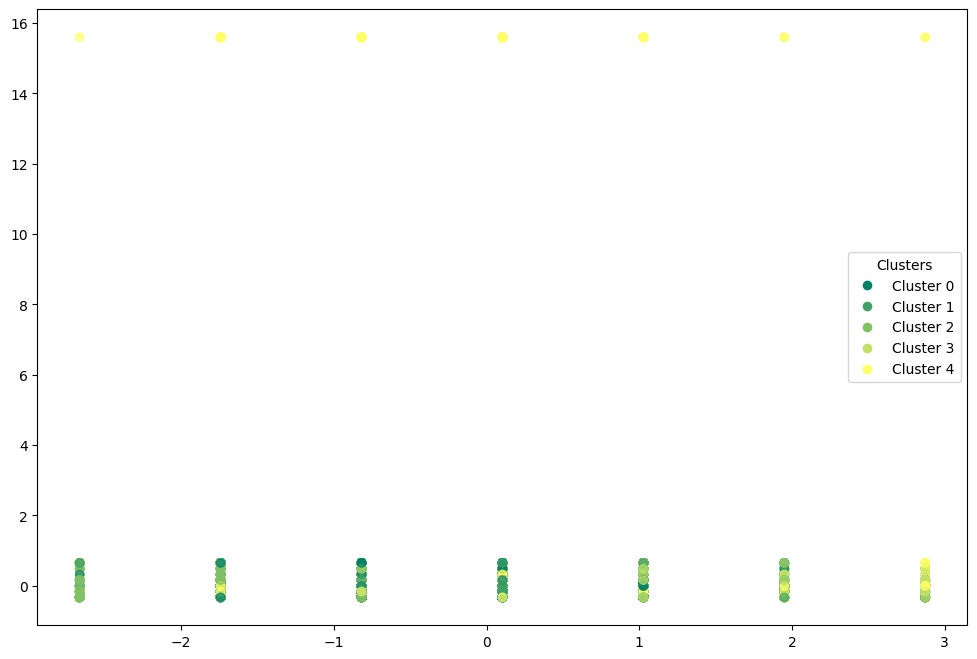

In [169]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 1], df_tsne_kmeans.iloc[:, 2], 
                      c=df_tsne_kmeans['kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_kmeans['kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [170]:
df_tsne_kmeans.groupby(df_tsne_kmeans['kmeans_tsne']).mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
kmeans_tsne,,,,,,,,,,,,,,,,,,,
0,0.212133,0.061145,-0.048002,0.445428,0.307801,0.056370,0.624979,-0.037039,-0.070391,-0.050570,-0.061301,-0.327295,-0.069141,-0.578001,-0.292825,-0.356761,0.310241,-0.031957,0.107901
1,0.216302,0.114572,-0.049320,-0.036159,0.370550,0.139510,-1.142024,0.026934,0.043646,0.175420,0.185246,-0.339433,0.146210,-0.382276,0.101042,0.093157,0.098496,-0.036764,-0.065339
2,-1.274799,-0.963315,-0.076112,-0.368140,0.205210,-0.957502,-0.192393,-0.479156,-0.456240,-0.420400,-0.334233,-0.345655,-0.069141,1.412532,-0.239888,-0.076699,-0.432624,-0.237313,-0.616026
3,0.596077,0.624278,-0.059707,-0.010153,-0.817773,0.612315,0.624038,0.392429,0.367124,0.424567,0.359018,-0.344047,-0.069141,-0.589838,0.154208,0.044764,0.187289,0.335713,0.516157
4,0.384897,0.243593,0.313498,-0.025113,-0.026028,0.227272,-0.001347,0.135308,0.162157,-0.158120,-0.184577,1.814602,0.100476,0.111090,0.382103,0.402908,-0.197436,-0.047729,0.075719


### k-means with umap

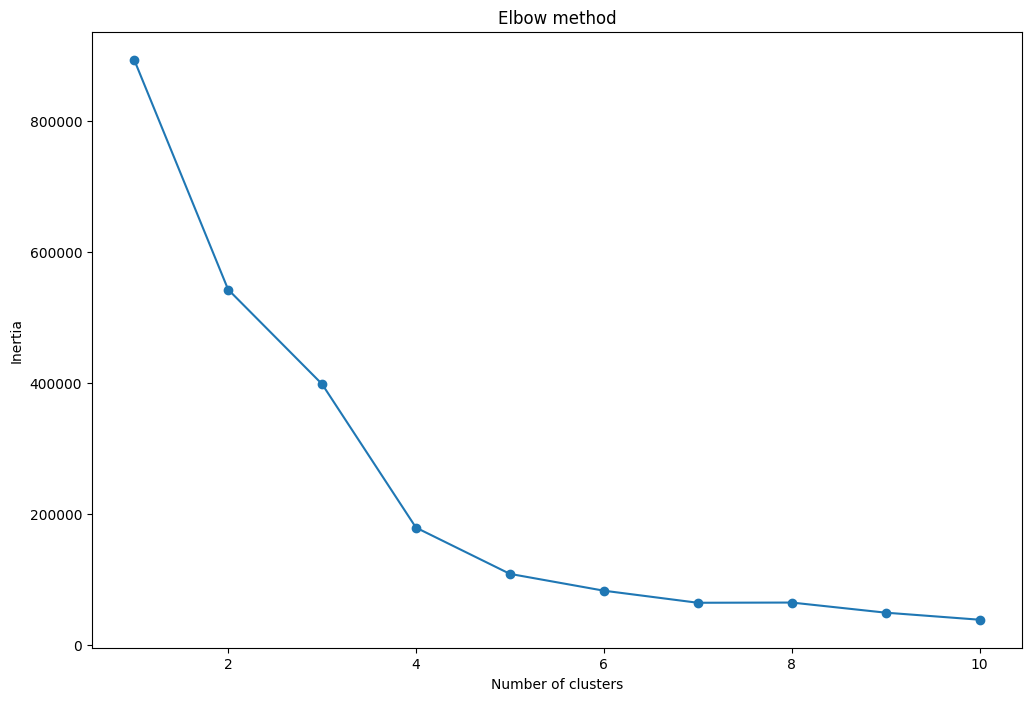

In [171]:
data = X_umap
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [172]:
kmeans_umap = KMeans(n_clusters=5,init='k-means++',random_state=42)

In [173]:
kmeans_umap.fit(X_umap)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [174]:
df_umap_kmeans = energy_scaled.copy()

In [175]:
df_umap_kmeans['kmeans_umap'] = kmeans_umap.labels_

In [176]:
df_umap_kmeans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,kmeans_umap
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,3
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,1
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,4
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


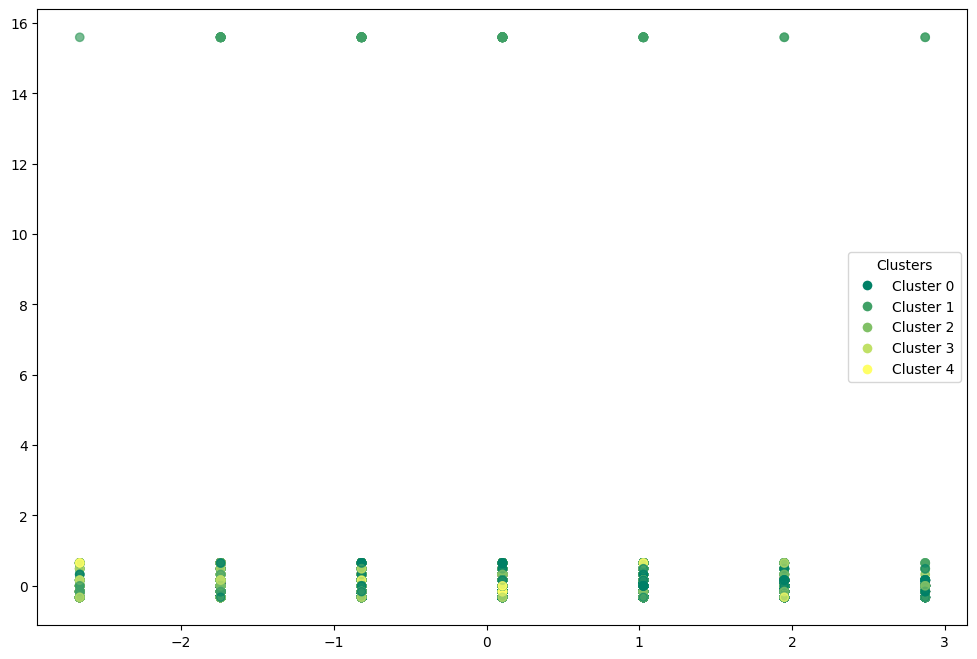

In [177]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_umap_kmeans.iloc[:, 1], df_umap_kmeans.iloc[:, 2], 
                      c=df_umap_kmeans['kmeans_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_kmeans['kmeans_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

## Birch

In [178]:
birch = Birch(branching_factor=50,n_clusters=5,threshold=1.5) 

In [179]:
birch.fit(energy_scaled)

,threshold,1.5
,branching_factor,50
,n_clusters,5
,compute_labels,True
,copy,'deprecated'


In [180]:
df_birch = energy_scaled.copy()

In [181]:
df_birch['birch'] = birch.labels_

In [182]:
df_birch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,birch
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,1
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,1
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


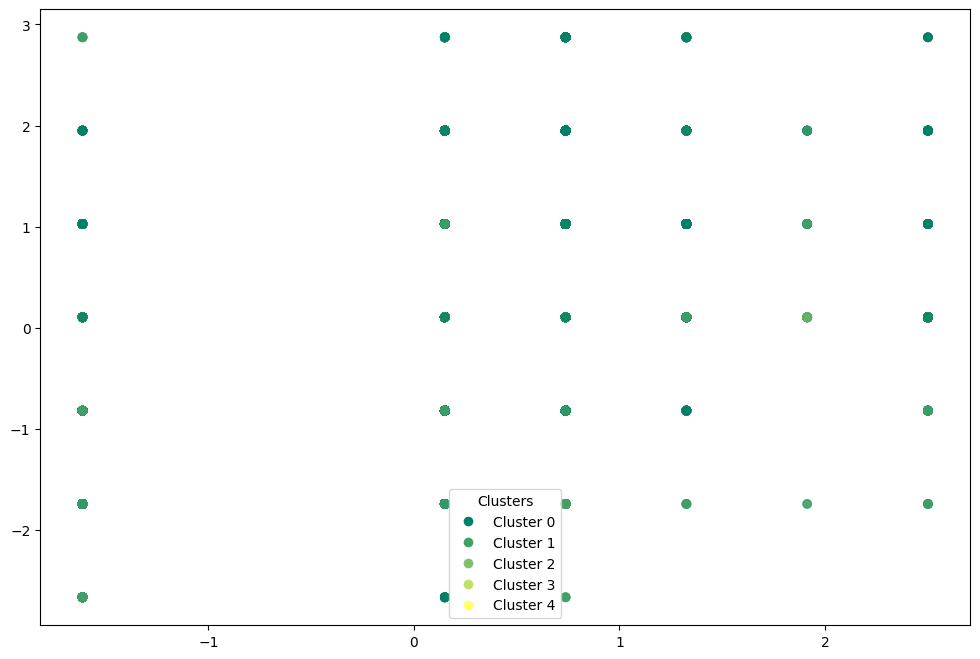

In [183]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_birch.iloc[:, 0], df_birch.iloc[:, 1], 
                      c=df_birch['birch'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_birch['birch'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### Birch with pca

In [184]:
birch_pca = Birch(branching_factor=50,n_clusters=5,threshold=1.5) 

In [185]:
birch_pca.fit(X_pca)

,threshold,1.5
,branching_factor,50
,n_clusters,5
,compute_labels,True
,copy,'deprecated'


In [186]:
df_pca_birch = energy_scaled.copy()

In [187]:
df_pca_birch["birch_pca"] = birch_pca.labels_

In [188]:
df_pca_birch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,birch_pca
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


### Birch with t-SNE

In [189]:
birch_tsne = Birch(branching_factor=50,n_clusters=5,threshold=1.5) 

In [190]:
birch_tsne.fit(X_tsne)

,threshold,1.5
,branching_factor,50
,n_clusters,5
,compute_labels,True
,copy,'deprecated'


In [191]:
df_tsne_birch = energy_scaled.copy()

In [192]:
df_tsne_birch['birch_tsne'] = birch_tsne.labels_

In [193]:
df_tsne_birch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,birch_tsne
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,3
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,3
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,4
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,4
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,2
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,4


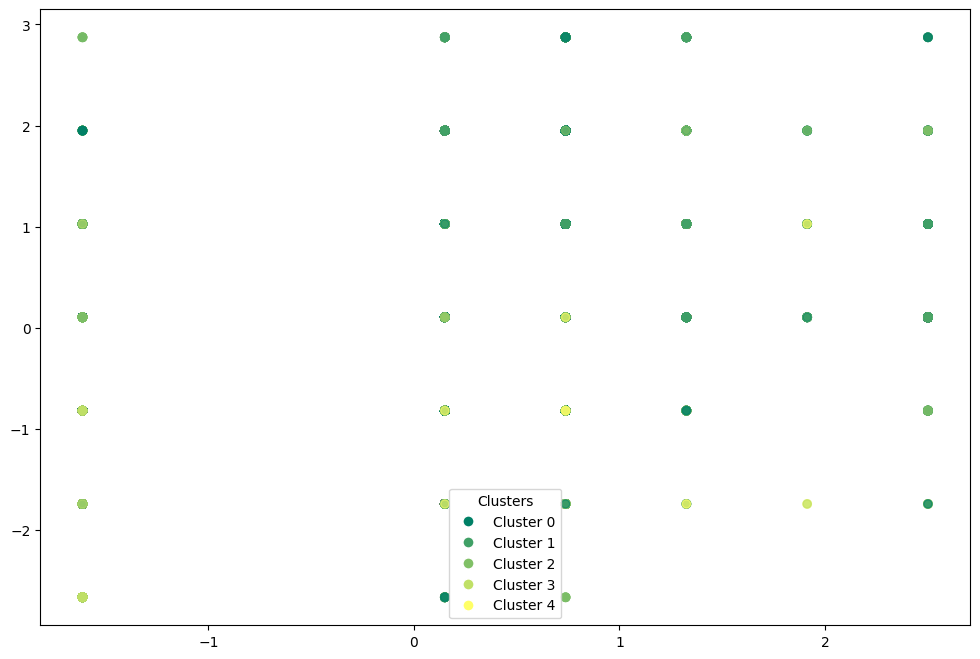

In [194]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_tsne_birch.iloc[:, 0], df_tsne_birch.iloc[:, 1], 
                      c=df_tsne_birch['birch_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_birch['birch_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### Birch with umap

In [195]:
birch_umap = Birch(branching_factor=50,n_clusters=5,threshold=1.5) 

In [196]:
birch_umap.fit(X_umap)

,threshold,1.5
,branching_factor,50
,n_clusters,5
,compute_labels,True
,copy,'deprecated'


In [197]:
df_umap_birch = energy_scaled.copy()

In [198]:
df_umap_birch['birch_umap'] = birch_umap.labels_

In [199]:
df_umap_birch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,birch_umap
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,1


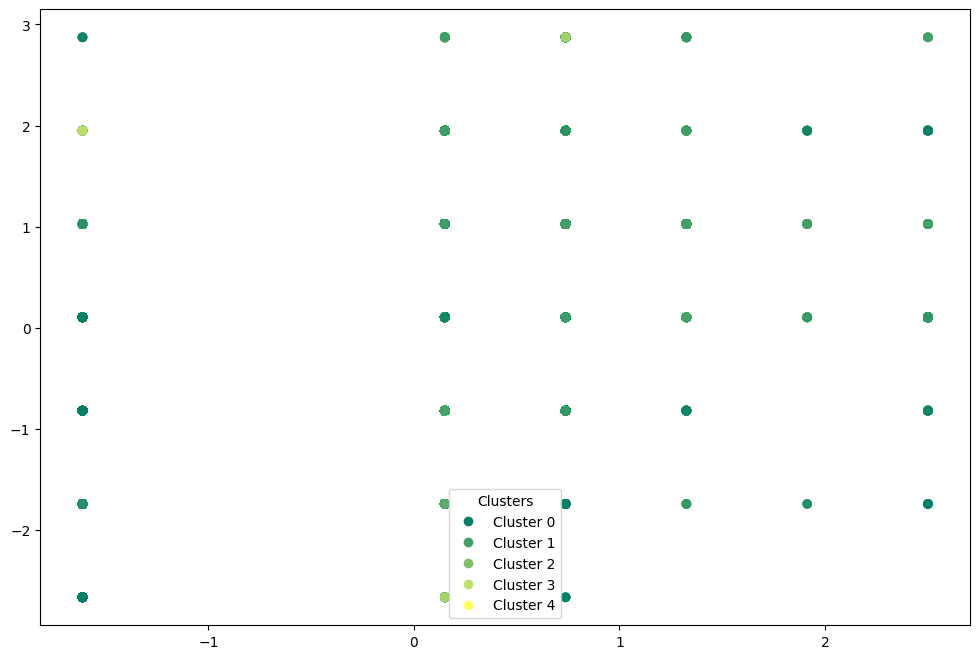

In [200]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_umap_birch.iloc[:, 0], df_umap_birch.iloc[:, 1], 
                      c=df_umap_birch['birch_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_birch['birch_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

## GMM - Gaussian Mixture Models

In [201]:
gmm = GaussianMixture(n_components=5,init_params='k-means++',random_state=42)

In [202]:
gmm.fit(energy_scaled)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'k-means++'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [203]:
df_gmm = energy_scaled.copy()

In [204]:
df_gmm['gmm'] = gmm.predict(energy_scaled)

In [205]:
df_gmm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,gmm
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,1
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,1
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,3
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,1
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,3


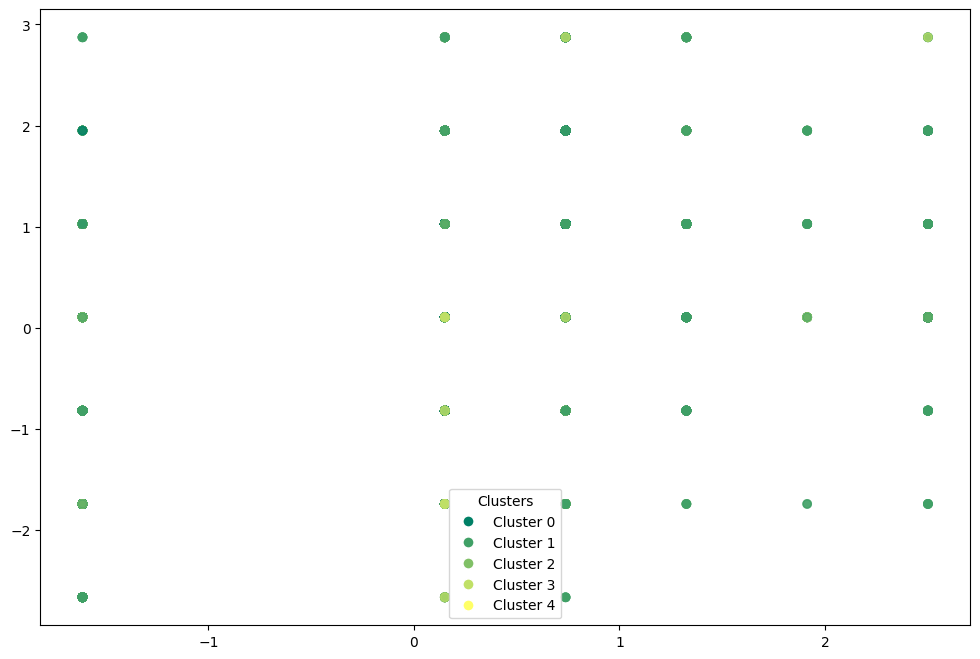

In [206]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_gmm.iloc[:, 0], df_gmm.iloc[:, 1], 
                      c=df_gmm['gmm'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_gmm['gmm'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### GMM with pca

In [207]:
gmm_pca = GaussianMixture(n_components=5,init_params='k-means++',random_state=42)

In [208]:
gmm_pca.fit(X_pca)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'k-means++'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [209]:
df_pca_gmm = energy_scaled.copy()

In [210]:
df_pca_gmm['gmm_pca'] = gmm_pca.predict(X_pca)

In [211]:
df_pca_gmm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,gmm_pca
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,2
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,2
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,1


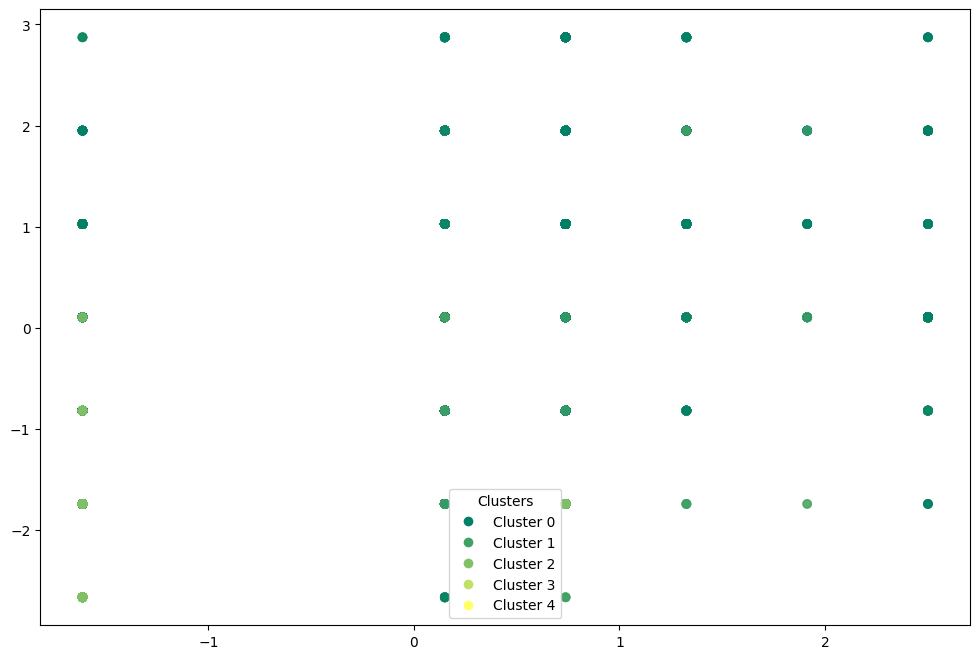

In [212]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pca_gmm.iloc[:, 0], df_pca_gmm.iloc[:, 1], 
                      c=df_pca_gmm['gmm_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_gmm['gmm_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### GMM with t-SNE

In [213]:
gmm_tsne = GaussianMixture(n_components=5,init_params='k-means++',random_state=42)

In [214]:
gmm_tsne.fit(X_tsne)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'k-means++'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [215]:
df_tsne_gmm = energy_scaled.copy()

In [216]:
df_tsne_gmm['gmm_tsne'] = gmm_tsne.predict(X_tsne)

In [217]:
df_tsne_gmm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,gmm_tsne
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,2
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


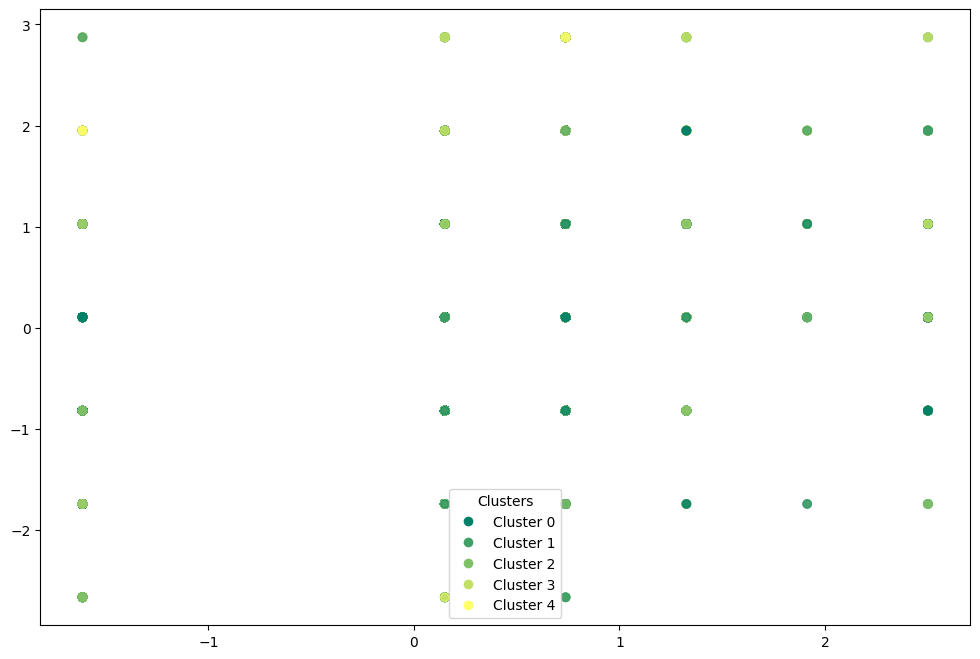

In [218]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_tsne_gmm.iloc[:, 0], df_tsne_gmm.iloc[:, 1], 
                      c=df_tsne_gmm['gmm_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_gmm['gmm_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### GMM with umap

In [219]:
gmm_umap = GaussianMixture(n_components=5,init_params='k-means++',random_state=42)

In [220]:
gmm_umap.fit(X_umap)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'k-means++'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [221]:
df_umap_gmm = energy_scaled.copy()

In [222]:
df_umap_gmm['gmm_umap'] = gmm_umap.predict(X_umap)

In [223]:
df_umap_gmm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,gmm_umap
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,3
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,1
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,4
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


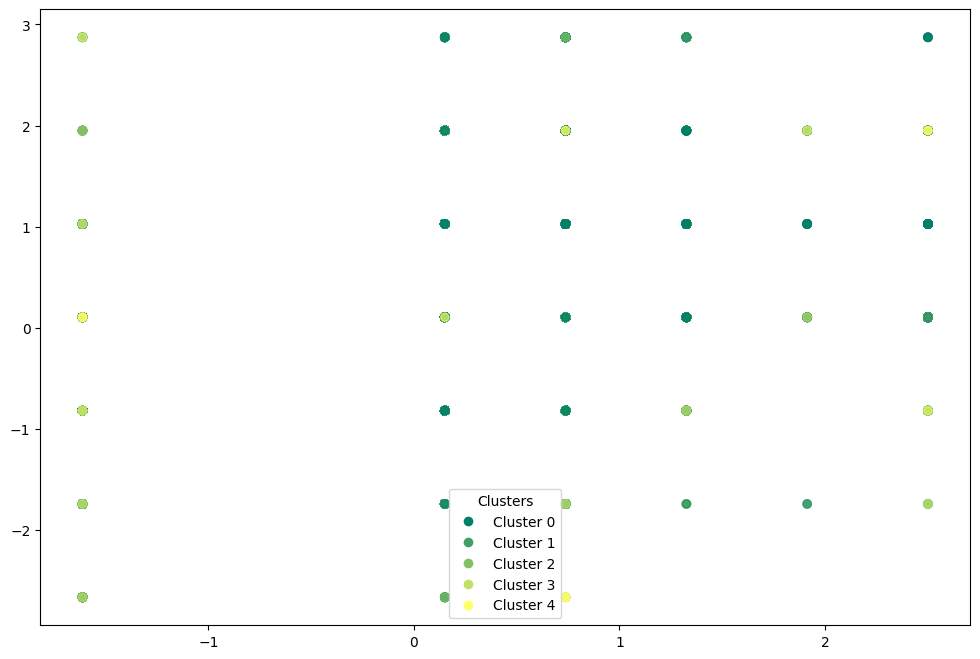

In [224]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_umap_gmm.iloc[:, 0], df_umap_gmm.iloc[:, 1], 
                      c=df_umap_gmm['gmm_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_gmm['gmm_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

## pam

In [225]:
initial_medoids = np.random.choice(len(energy_scaled),5,replace=False)

In [226]:
metric = distance_metric(type_metric.EUCLIDEAN)

In [227]:
pam = kmedoids(energy_scaled.values.tolist(),initial_medoids,metric=metric)

In [228]:
pam.process()

In [229]:
clusters = pam.get_clusters()

In [230]:
medoids = pam.get_medoids()

In [231]:
labels = np.zeros(len(energy_scaled))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [232]:
df_pam = energy_scaled.copy()

In [233]:
df_pam['pam'] = labels

In [234]:
df_pam

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,pam
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,3.0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,4.0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,4.0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,3.0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1.0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0.0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,4.0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0.0


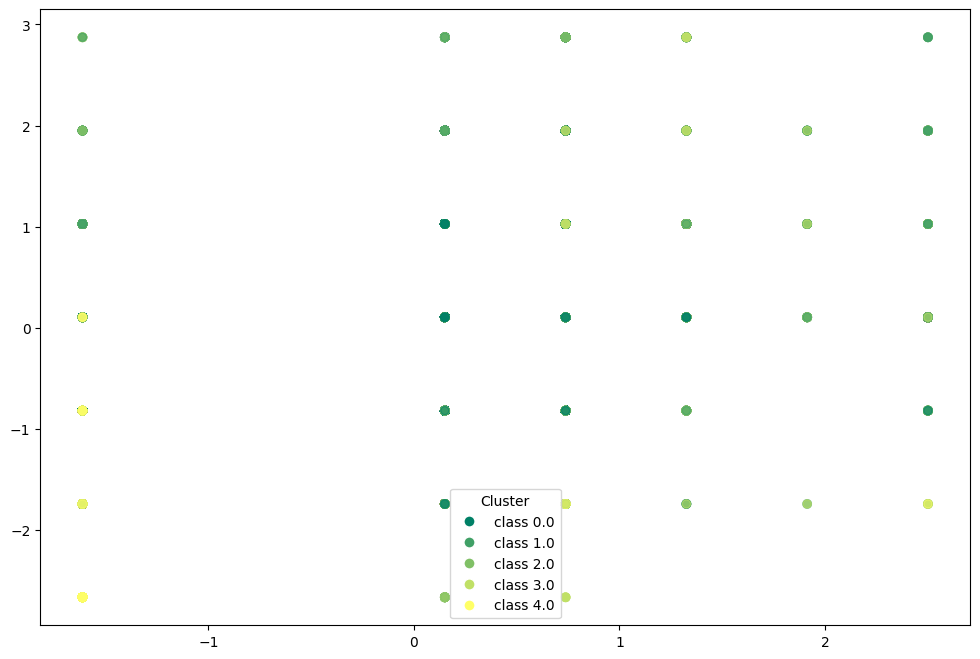

In [235]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pam.iloc[:, 0],df_pam.iloc[:, 1], 
                      c=df_pam['pam'],cmap='summer',alpha=0.7)

unique_labels = np.unique(df_pam['pam'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

### pam with pca

In [236]:
initial_medoids = np.random.choice(len(X_pca),5,replace=False)

In [237]:
metric = distance_metric(type_metric.EUCLIDEAN)

In [238]:
pam_pca = kmedoids(X_pca,initial_medoids,metric=metric)

In [239]:
pam_pca.process()

In [240]:
clusters = pam_pca.get_clusters()

In [241]:
medoids = pam_pca.get_medoids()

In [242]:
labels = np.zeros(len(X_pca))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [243]:
df_pam_pca = energy_scaled.copy()

In [244]:
df_pam_pca['pam_pca'] = labels

In [245]:
df_pam_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,pam_pca
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0.0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,3.0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,3.0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0.0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,4.0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1.0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,4.0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,2.0


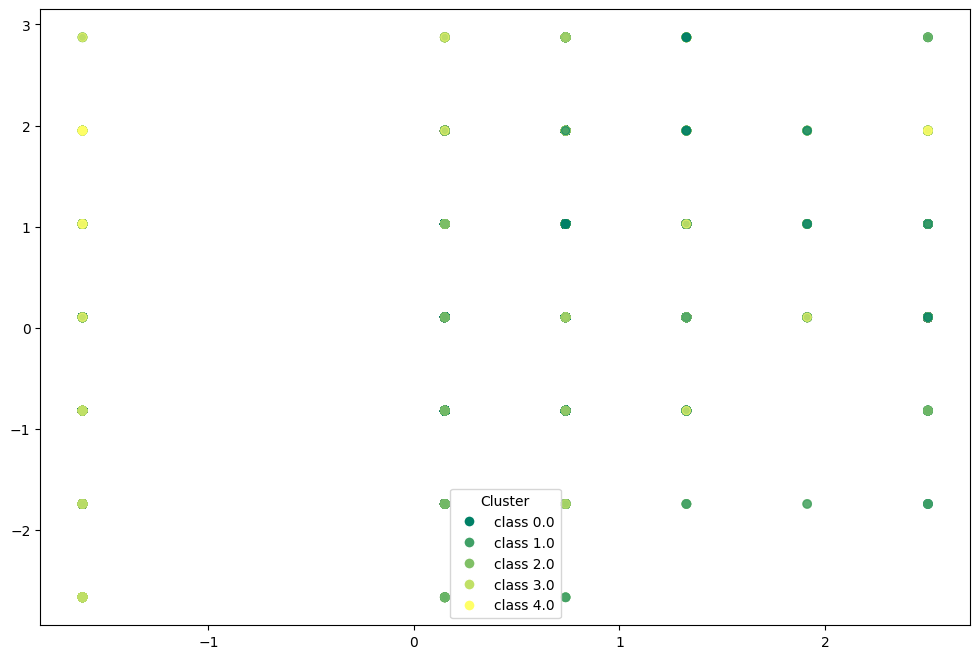

In [246]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pam_pca.iloc[:, 0],df_pam_pca.iloc[:, 1], 
                      c=df_pam_pca['pam_pca'],cmap='summer',alpha=0.7)

unique_labels = np.unique(df_pam_pca['pam_pca'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

### pam with t-SNE

In [247]:
initial_medoids = np.random.choice(len(X_tsne),5,replace=False)

In [248]:
metric = distance_metric(type_metric.EUCLIDEAN)

In [249]:
pam_tsne = kmedoids(X_tsne,initial_medoids,metric=metric)

In [250]:
pam_tsne.process()

In [251]:
clusters = pam_tsne.get_clusters()

In [252]:
medoids = pam_tsne.get_medoids()

In [253]:
labels = np.zeros(len(X_tsne))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [254]:
df_pam_tsne = energy_scaled.copy()

In [255]:
df_pam_tsne['pam_tsne'] = labels

In [256]:
df_pam_tsne

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,pam_tsne
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,2.0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,4.0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,4.0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,2.0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,3.0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,2.0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,3.0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,2.0


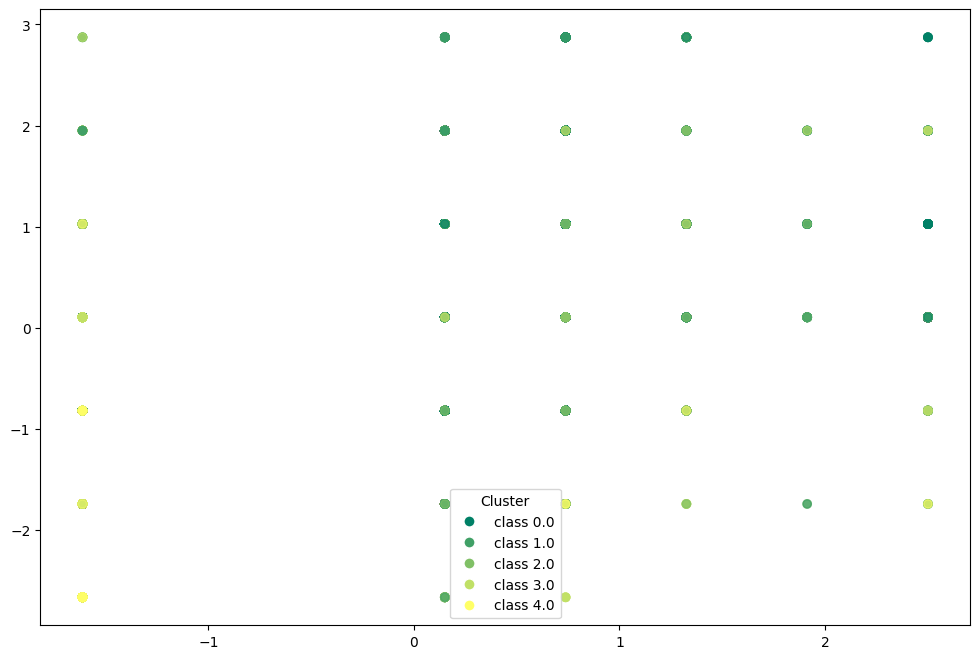

In [257]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pam_tsne.iloc[:, 0],df_pam_tsne.iloc[:, 1], 
                      c=df_pam_tsne['pam_tsne'],cmap='summer',alpha=0.7)

unique_labels = np.unique(df_pam_tsne['pam_tsne'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

### pam with umap

In [258]:
initial_medoids = np.random.choice(len(X_umap),5,replace=False)

In [259]:
metric = distance_metric(type_metric.EUCLIDEAN)

In [260]:
pam_umap = kmedoids(X_umap,initial_medoids,metric=metric)

In [261]:
pam_umap.process()

In [262]:
clusters = pam_umap.get_clusters()

In [263]:
medoids = pam_umap.get_medoids()

In [264]:
labels = np.zeros(len(X_umap))
for cluster_idx, cluster in enumerate(clusters):
    for data_idx in cluster:
        labels[data_idx] = cluster_idx

In [265]:
df_pam_umap = energy_scaled.copy()

In [266]:
df_pam_umap['pam_umap'] = labels

In [267]:
df_pam_umap

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,pam_umap
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0.0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,1.0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,3.0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0.0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0.0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0.0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,2.0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0.0


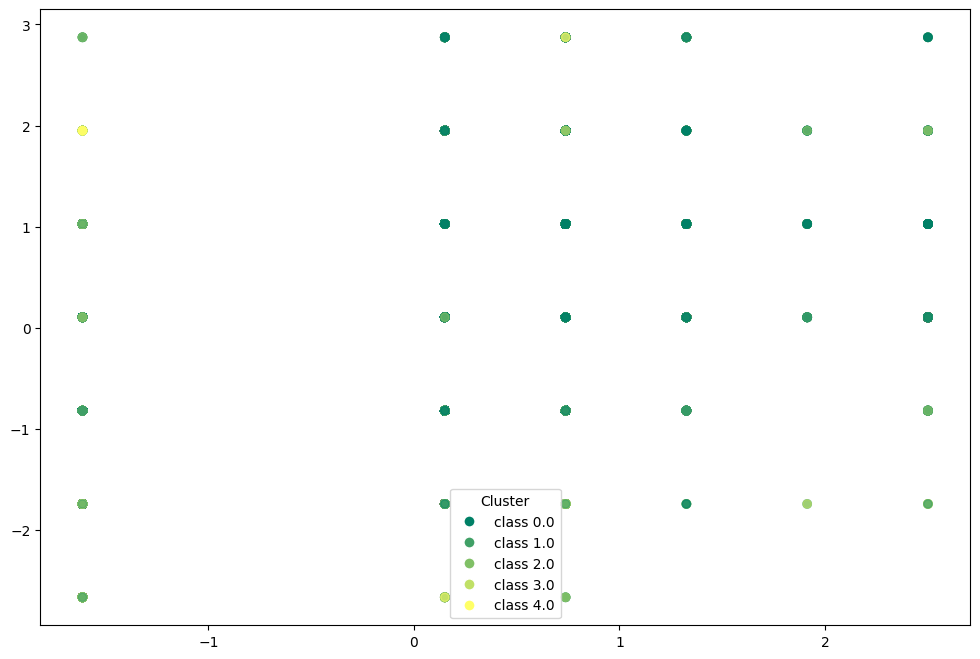

In [268]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_pam_umap.iloc[:, 0],df_pam_umap.iloc[:, 1], 
                      c=df_pam_umap['pam_umap'],cmap='summer',alpha=0.7)

unique_labels = np.unique(df_pam_umap['pam_umap'])
legend_elements = [Line2D([0], [0],marker='o',color='w',label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements,title="Cluster")
plt.show()

## spectral clustering

In [269]:
spectral_clustering = SpectralClustering(n_clusters=5,affinity ='nearest_neighbors')

In [270]:
spectral_clustering.fit(energy_scaled)

,n_clusters,5
,eigen_solver,None
,n_components,None
,random_state,None
,n_init,10
,gamma,1.0
,affinity,'nearest_neighbors'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [271]:
df_spectral = energy_scaled.copy()

In [272]:
df_spectral['spectral_clustering'] = spectral_clustering.labels_

In [273]:
df_spectral

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,spectral_clustering
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,1
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,1


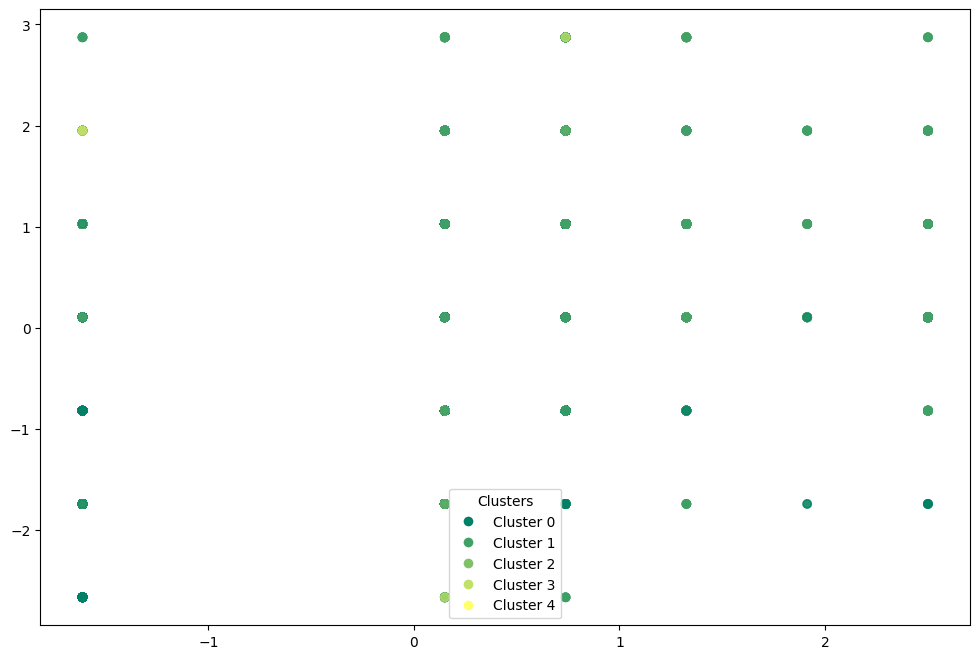

In [274]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_spectral.iloc[:, 0], df_spectral.iloc[:, 1], 
                      c=df_spectral['spectral_clustering'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_spectral['spectral_clustering'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### spectral clustering with pca

In [275]:
spectral_pca = SpectralClustering(n_clusters=5,affinity ='nearest_neighbors')

In [276]:
spectral_pca.fit(X_pca)

,n_clusters,5
,eigen_solver,None
,n_components,None
,random_state,None
,n_init,10
,gamma,1.0
,affinity,'nearest_neighbors'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [277]:
df_pca_spectral = energy_scaled.copy()

In [278]:
df_pca_spectral["spectral_pca"] = spectral_pca.labels_

In [279]:
df_pca_spectral

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,spectral_pca
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,2
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


### spectral clustering with t-SNE

In [280]:
spectral_tsne = SpectralClustering(n_clusters=5,affinity ='nearest_neighbors')

In [281]:
spectral_tsne.fit(X_tsne)

,n_clusters,5
,eigen_solver,None
,n_components,None
,random_state,None
,n_init,10
,gamma,1.0
,affinity,'nearest_neighbors'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [282]:
df_tsne_spectral = energy_scaled.copy()

In [283]:
df_tsne_spectral['spectral_tsne'] = spectral_tsne.labels_

In [284]:
df_tsne_spectral

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,spectral_tsne
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,1
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,4
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,2
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,1
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,1
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,1
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,1


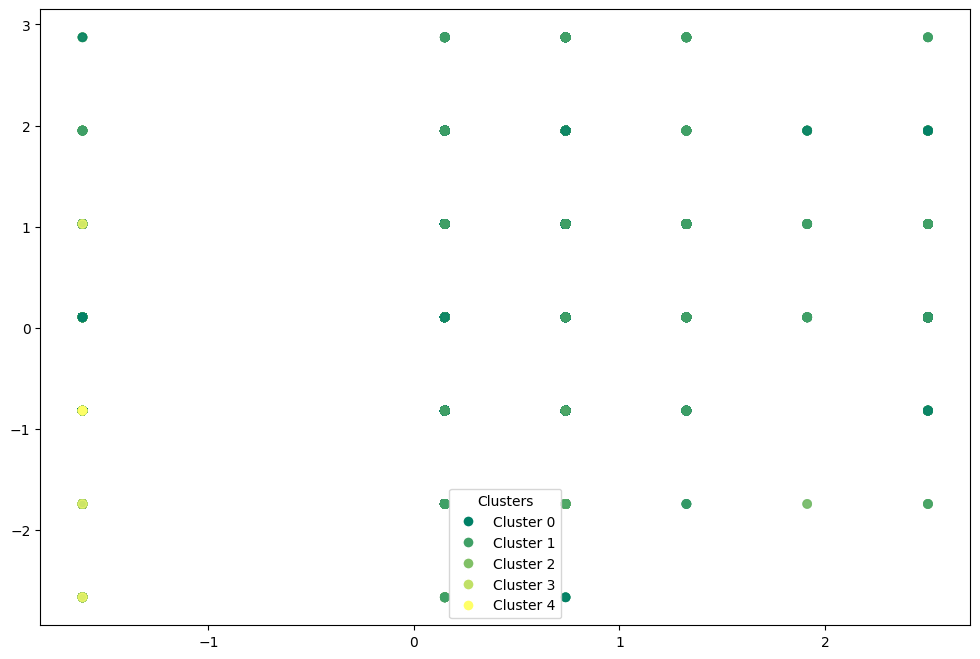

In [285]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(df_tsne_spectral.iloc[:, 0], df_tsne_spectral.iloc[:, 1], 
                      c=df_tsne_spectral['spectral_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_spectral['spectral_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### spectral clustering with umap

In [286]:
spectral_umap = SpectralClustering(n_clusters=5,affinity ='nearest_neighbors')

In [287]:
spectral_umap.fit(X_umap)

,n_clusters,5
,eigen_solver,None
,n_components,None
,random_state,None
,n_init,10
,gamma,1.0
,affinity,'nearest_neighbors'
,n_neighbors,10
,eigen_tol,'auto'
,assign_labels,'kmeans'
,degree,3


In [288]:
df_umap_spectral = energy_scaled.copy()

In [289]:
df_umap_spectral['spectral_umap'] = spectral_umap.labels_

In [290]:
df_umap_spectral

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,spectral_umap
0,0.150514,1.027113,-0.330784,0.027401,0.131578,0.078520,0.585990,0.235203,0.615100,1.812998,0.632574,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.591947,1.445164,0.337489,0
1,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,0.585990,-0.788260,-0.825391,-0.569167,-0.277865,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.402702,-0.314414,-1.402322,0
2,-1.612200,-1.741661,-0.330784,-0.643114,0.131578,-2.018161,-1.431595,-1.189776,-1.264758,-0.221501,-0.430101,-0.345655,-0.069141,1.520967,-1.065881,-0.544664,1.576435,0.565375,-0.159600,0
3,0.738086,-0.818736,-0.005798,0.027401,0.131578,0.777413,0.585990,-0.221294,0.000062,0.390651,0.498273,-0.345655,-0.069141,-0.599308,-0.336253,-0.544664,0.881503,-0.314414,-0.408145,0
4,-1.612200,-1.741661,0.644173,-0.643114,0.131578,-2.018161,0.585990,-0.700143,-0.391860,0.013424,-0.041391,-0.345655,-0.069141,1.520967,-0.336253,-0.544664,-1.434939,1.445164,1.083122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,0.738086,0.104188,-0.005798,0.027401,-1.222718,0.078520,0.585990,-0.732677,-0.866131,-0.149043,0.050294,-0.345655,-0.069141,-0.599308,1.123001,1.587648,-1.029561,1.445164,-2.396500,0
18492,0.150514,0.104188,-0.005798,0.027401,0.131578,0.078520,0.585990,-0.903263,-0.898832,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.186570,-1.194203,0.337489,0
18493,-1.612200,0.104188,-0.005798,-0.164175,0.131578,0.078520,-1.431595,0.600772,0.004064,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,1.123001,0.521492,-1.724494,-0.314414,-0.905233,0
18494,0.738086,0.104188,0.156694,0.027401,0.131578,1.476307,0.585990,1.090551,0.925786,-0.792875,-0.819308,-0.345655,-0.069141,-0.599308,-1.065881,-0.544664,0.649858,0.565375,0.586033,0


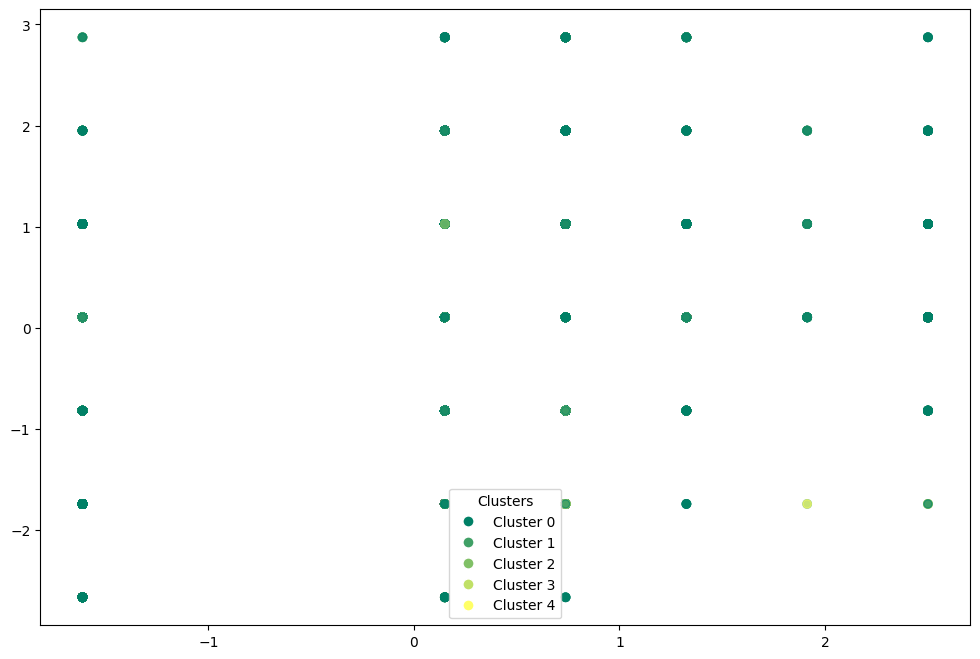

In [291]:
plt.figure(figsize=(12,8)) 
scatter = plt.scatter(df_umap_spectral.iloc[:, 0], df_umap_spectral.iloc[:, 1], 
                      c=df_umap_spectral['spectral_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_spectral['spectral_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()